In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from pathlib import Path
import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json
import re
import json
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "simple_white"
# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()
for dirname,_,filename in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))


In [30]:
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)

# convert dictionary to pandas dataframe
CHAR2ORD_DF = pd.DataFrame(CHAR2ORD.values(),index=CHAR2ORD.keys(),columns=['Ordinal Encoding'])
CHAR2ORD_DF.head(10)

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


## Tổng tất cả có bao nhiêu ký tự

In [31]:
N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'N_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

N_UNIQUE_CHARACTERS: 59


###### Đọc code lại

In [32]:
def map_new_to_old_style(sequence):
    types = []
    landmark_indexes = []
    for column in list(sequence.columns)[1:544]:
        parts = column.split("_")
        if len(parts) == 4:
            types.append(parts[1] + "_" + parts[2])
        else:
            types.append(parts[1])

        landmark_indexes.append(int(parts[-1]))

    data = {
        "frame": [],
        "type": [],
        "landmark_index": [],
        "x": [],
        "y": [],
        "z": []
    }

    for index, row in sequence.iterrows():
        data["frame"] += [int(row.frame)]*543
        data["type"] += types
        data["landmark_index"] += landmark_indexes

        for _type, landmark_index in zip(types, landmark_indexes):
            data["x"].append(row[f"x_{_type}_{landmark_index}"])
            data["y"].append(row[f"y_{_type}_{landmark_index}"])
            data["z"].append(row[f"z_{_type}_{landmark_index}"])

    return pd.DataFrame.from_dict(data)

# assign desired colors to landmarks
def assign_color(row):
    if row == 'face':
        return 'red'
    elif 'hand' in row:
        return 'dodgerblue'
    else:
        return 'green'

# specifies the plotting order
def assign_order(row):
    if row.type == 'face':
        return row.landmark_index + 101
    elif row.type == 'pose':
        return row.landmark_index + 30
    elif row.type == 'left_hand':
        return row.landmark_index + 80
    else:
        return row.landmark_index

def visualise2d_landmarks(parquet_df, title=""):
    connections = [  
        [0, 1, 2, 3, 4,],
        [0, 5, 6, 7, 8],
        [0, 9, 10, 11, 12],
        [0, 13, 14, 15, 16],
        [0, 17, 18, 19, 20],

        
        [38, 36, 35, 34, 30, 31, 32, 33, 37],
        [40, 39],
        [52, 46, 50, 48, 46, 44, 42, 41, 43, 45, 47, 49, 45, 51],
        [42, 54, 56, 58, 60, 62, 58],
        [41, 53, 55, 57, 59, 61, 57],
        [54, 53],

        
        [80, 81, 82, 83, 84, ],
        [80, 85, 86, 87, 88],
        [80, 89, 90, 91, 92],
        [80, 93, 94, 95, 96],
        [80, 97, 98, 99, 100], ]

    parquet_df = map_new_to_old_style(parquet_df)
    frames = sorted(set(parquet_df.frame))
    first_frame = min(frames)
    parquet_df['color'] = parquet_df.type.apply(lambda row: assign_color(row))
    parquet_df['plot_order'] = parquet_df.apply(lambda row: assign_order(row), axis=1)
    first_frame_df = parquet_df[parquet_df.frame == first_frame].copy()
    first_frame_df = first_frame_df.sort_values(["plot_order"]).set_index('plot_order')


    frames_l = []
    for frame in frames:
        filtered_df = parquet_df[parquet_df.frame == frame].copy()
        filtered_df = filtered_df.sort_values(["plot_order"]).set_index("plot_order")
        traces = [go.Scatter(
            x=filtered_df['x'],
            y=filtered_df['y'],
            mode='markers',
            marker=dict(
                color=filtered_df.color,
                size=9))]

        for i, seg in enumerate(connections):
            trace = go.Scatter(
                    x=filtered_df.loc[seg]['x'],
                    y=filtered_df.loc[seg]['y'],
                    mode='lines',
            )
            traces.append(trace)
        frame_data = go.Frame(data=traces, traces = [i for i in range(17)])
        frames_l.append(frame_data)

    traces = [go.Scatter(
        x=first_frame_df['x'],
        y=first_frame_df['y'],
        mode='markers',
        marker=dict(
            color=first_frame_df.color,
            size=9
        )
    )]
    for i, seg in enumerate(connections):
        trace = go.Scatter(
            x=first_frame_df.loc[seg]['x'],
            y=first_frame_df.loc[seg]['y'],
            mode='lines',
            line=dict(
                color='black',
                width=2
            )
        )
        traces.append(trace)
    fig = go.Figure(
        data=traces,
        frames=frames_l
    )


    fig.update_layout(
        width=500,
        height=800,
        scene={
            'aspectmode': 'data',
        },
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [None, {"frame": {"duration": 100,
                                                  "redraw": True},
                                        "fromcurrent": True,
                                        "transition": {"duration": 0}}],
                        "label": "&#9654;",
                        "method": "animate",
                    },

                ],
                "direction": "left",
                "pad": {"r": 100, "t": 100},
                "font": {"size":30},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
        ],
    )
    camera = dict(
        up=dict(x=0, y=-1, z=0),
        eye=dict(x=0, y=0, z=2.5)
    )
    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_layout(scene_camera=camera, showlegend=False)
    fig.update_layout(xaxis = dict(visible=False),
            yaxis = dict(visible=False),
    )
    fig.update_yaxes(autorange="reversed")

    fig.show()
def get_phrase(df, file_id, sequence_id):
    return df[
        np.logical_and(
            df.file_id == file_id,
            df.sequence_id == sequence_id
        )
    ].phrase.iloc[0]

## EDA

In [33]:
train_df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
supplemental_df = pd.read_csv('/kaggle/input/asl-fingerspelling/supplemental_metadata.csv')
pd.set_option('display.max_columns', None)
print(f"Total number of files in metadata: {supplemental_df.shape[0]}")
print(f"Total number of participants in metadata : {supplemental_df.participant_id.nunique()}")
print(f"Total number of unique phrases in metadata : {supplemental_df.phrase.nunique()}")
supplemental_df.head(10)

Total number of files in metadata: 52958
Total number of participants in metadata : 72
Total number of unique phrases in metadata : 508


,path,file_id,sequence_id,participant_id,phrase
0,supplemental_landmarks/33432165.parquet,33432165,1535467051,251,coming up with killer sound bites
1,supplemental_landmarks/33432165.parquet,33432165,1535499058,239,we better investigate this
2,supplemental_landmarks/33432165.parquet,33432165,1535530550,245,interesting observation was made
3,supplemental_landmarks/33432165.parquet,33432165,1535545499,38,victims deserve more redress
4,supplemental_landmarks/33432165.parquet,33432165,1535585216,254,knee bone is connected to the thigh bone
5,supplemental_landmarks/33432165.parquet,33432165,1535608427,253,stability of the nation
6,supplemental_landmarks/33432165.parquet,33432165,1535623283,254,all work and no play
7,supplemental_landmarks/33432165.parquet,33432165,1535642174,121,did you have a good time
8,supplemental_landmarks/33432165.parquet,33432165,1535731745,54,you should visit to a doctor
9,supplemental_landmarks/33432165.parquet,33432165,1535832199,253,i cannot believe i ate the whole thing


In [34]:
print(f"Total number of files : {train_df.shape[0]}")
print(f"Total number of Participant in the dataset : {train_df.participant_id.nunique()}")
print(f"Total number of unique phrases : {train_df.phrase.nunique()}")
train_df

Total number of files : 67208
Total number of Participant in the dataset : 94
Total number of unique phrases : 46478


,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
...,...,...,...,...,...
67203,train_landmarks/2118949241.parquet,2118949241,388192924,88,431-366-2913
67204,train_landmarks/2118949241.parquet,2118949241,388225542,154,994-392-3850
67205,train_landmarks/2118949241.parquet,2118949241,388232076,95,https://www.tianjiagenomes.com
67206,train_landmarks/2118949241.parquet,2118949241,388235284,36,90 kerwood circle


In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


In [36]:
supplemental_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52958 entries, 0 to 52957
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            52958 non-null  object
 1   file_id         52958 non-null  int64 
 2   sequence_id     52958 non-null  int64 
 3   participant_id  52958 non-null  int64 
 4   phrase          52958 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.0+ MB


In [37]:
def count_feature_data(data, feature,return_df=False):
  feature_count = data[feature]
  print(f'number', len(feature_count))
  unique_feature = data[feature].unique()
  print(f'number of {feature} unique: ',len(unique_feature))
  if return_df == 1:
    feature_counts = data[feature].value_counts()
    feature_data = pd.DataFrame({ feature: feature_counts.index, feature+'_count': feature_counts.values})
    return feature_data

## Tính theo câu (phrase) và tính theo người làm (participant_id)

#### Theo phrase

In [38]:
phrase_count=count_feature_data(train_df,'phrase',return_df=True)
phrase_count.head(10)

number 67208
number of phrase unique:  46478


,phrase,phrase_count
0,surprise az,17
1,fort worth tx,16
2,yonkers new york,16
3,raleigh north carolina,15
4,buffalo ny,14
5,north charleston south carolina,13
6,alexandria virginia,13
7,sugar land tx,12
8,overland park ks,12
9,honolulu hi,12


In [39]:
phrase_count=count_feature_data(supplemental_df,'phrase',return_df=True)
phrase_count.head(10)

number 52958
number of phrase unique:  508


,phrase,phrase_count
0,why do you ask silly questions,117
1,find a nearby parking spot,117
2,apartments are too expensive,116
3,what to do when the oil runs dry,115
4,that agreement is rife with problems,115
5,most judges are very honest,115
6,do not lie in court or else,115
7,the minimum amount of time,115
8,the biggest hamburger i have ever seen,115
9,where did you get such a silly idea,115


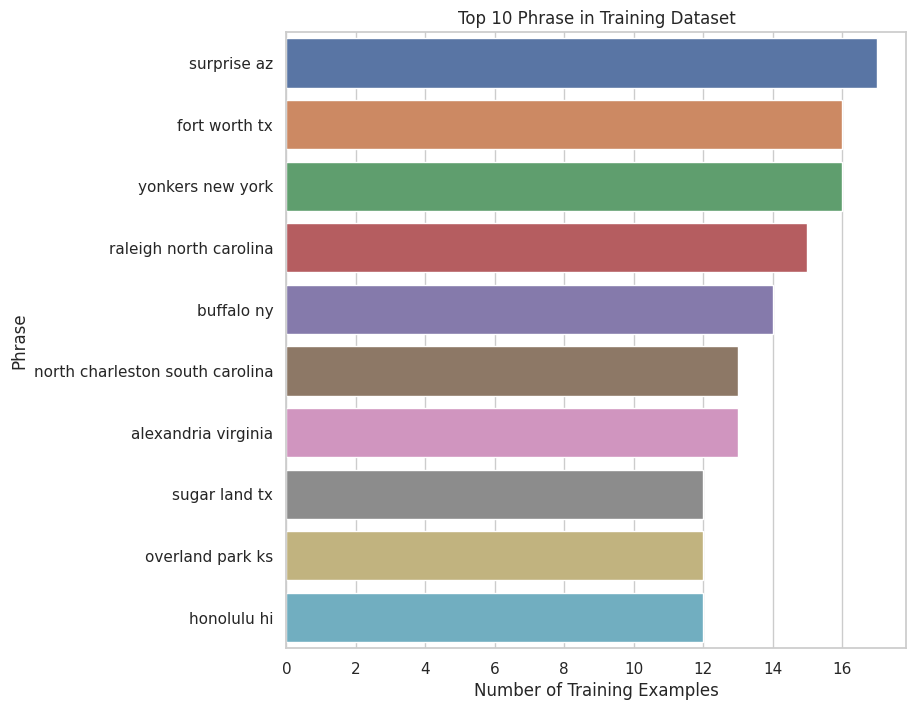

In [40]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(
    y=train_df["phrase"].value_counts().head(10).sort_values(ascending=False).index,
    x=train_df['phrase'].value_counts().head(10).sort_values(ascending=False),
    ax=ax,
)

ax.set_title("Top 10 Phrase in Training Dataset")
ax.set_xlabel("Number of Training Examples")
ax.set_ylabel("Phrase")
plt.show()

#### Theo participant

In [41]:
participant_id_count=count_feature_data(train_df,'participant_id',return_df=True)
participant_id_count

number 67208
number of participant_id unique:  94


,participant_id,participant_id_count
0,36,1535
1,105,1006
2,112,953
3,81,944
4,89,896
...,...,...
89,40,241
90,117,26
91,122,18
92,159,9


In [42]:
participant_id_count=count_feature_data(supplemental_df,'participant_id',return_df=True)
participant_id_count

number 52958
number of participant_id unique:  72


,participant_id,participant_id_count
0,227,1151
1,107,1059
2,188,988
3,2,986
4,112,986
...,...,...
67,184,64
68,113,60
69,56,57
70,51,51


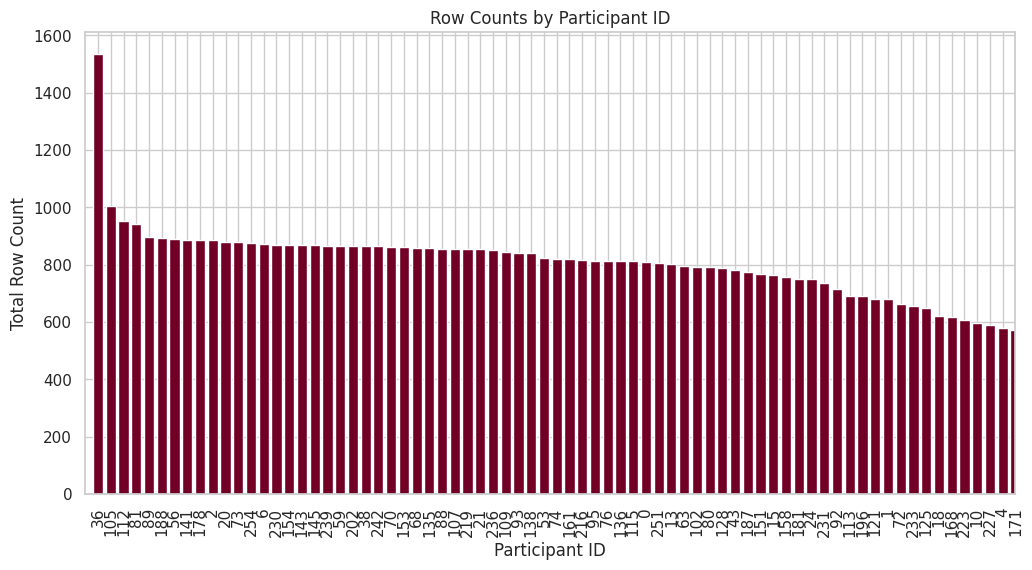

In [43]:
# Set the custom color scheme
color_scheme = ["#4f000b", "#720026", "#ce4257", "#ff7f51", "#ff9b54"]
train_df["participant_id"] = train_df["participant_id"].astype(str)
counts = train_df["participant_id"].value_counts()
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the histogram
bars = ax.bar(counts.index, counts.values, color=color_scheme[1])
# Set the labels and title
ax.set_xlabel("Participant ID")
ax.set_ylabel("Total Row Count")
ax.set_title("Row Counts by Participant ID")

# Rotate the x-axis labels if needed
plt.xticks(rotation=90, ha='center')
plt.xlim(-1, 72)

# Show the plot
plt.show()

### Tách ra từng ký tự

In [44]:
def split_phrase(input_df):
    input_df['phrase_char'] = input_df['phrase'].apply(tuple)
    # Character Length of Phrase
    input_df['phrase_char_len'] = input_df['phrase_char'].apply(len)
    # Maximum Input Length
    MAX_PHRASE_LENGTH = input_df['phrase_char_len'].max()
    print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')
    # Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
    train_sequence_id = input_df.set_index('sequence_id')

In [45]:
split_phrase(train_df)
split_phrase(supplemental_df)

MAX_PHRASE_LENGTH: 31
MAX_PHRASE_LENGTH: 43


In [46]:
train_df

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25
...,...,...,...,...,...,...,...
67203,train_landmarks/2118949241.parquet,2118949241,388192924,88,431-366-2913,"(4, 3, 1, -, 3, 6, 6, -, 2, 9, 1, 3)",12
67204,train_landmarks/2118949241.parquet,2118949241,388225542,154,994-392-3850,"(9, 9, 4, -, 3, 9, 2, -, 3, 8, 5, 0)",12
67205,train_landmarks/2118949241.parquet,2118949241,388232076,95,https://www.tianjiagenomes.com,"(h, t, t, p, s, :, /, /, w, w, w, ., t, i, a, ...",30
67206,train_landmarks/2118949241.parquet,2118949241,388235284,36,90 kerwood circle,"(9, 0, , k, e, r, w, o, o, d, , c, i, r, c, ...",17


Text(0, 0.5, 'Sample Count')

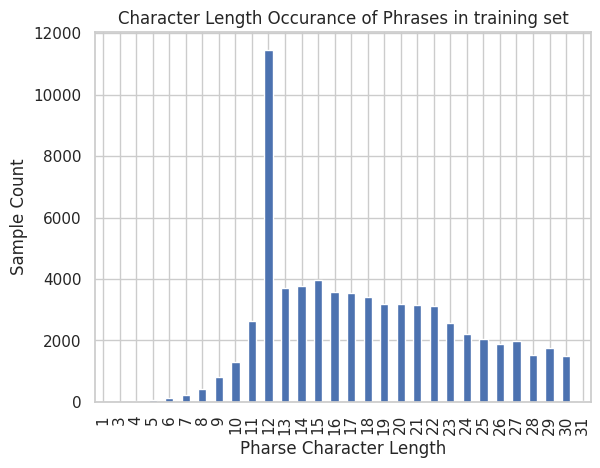

In [47]:
plt.title('Character Length Occurance of Phrases in training set')
train_df['phrase_char_len'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Pharse Character Length')
plt.ylabel('Sample Count')

In [48]:
character_count = {}
for phrase in train_df["phrase"]:
    for char in phrase:
        try:
            character_count[char] += 1
        except KeyError:
            character_count[char] = 1
character_count = dict(sorted(character_count.items(), key=lambda k: k[1], reverse=True))
fig = go.Figure(
    data=[
        go.Bar(
            x=list(character_count.keys()),
            y=list(character_count.values()),
            hovertemplate='Character: <b>%{x}</b><br>Count: <b>%{y}</b><extra></extra>'
        )
    ]
)
fig.update_traces(
    marker_color='rgb(158,202,225)',
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5,
)
fig.update_layout(
    title={
        'text':f'<b>Count of each character in training set</b>',
        'y':0.95,
        'x':0.5,
        'xanchor':'center',
        'yanchor':'top'
    },
    xaxis_title="Character",
    yaxis_title="Count",
    height=500,
    title_x=0.5,
    hoverlabel=dict(
        font_size=14,
    ),
    title_font_size=24,
    template="plotly_white",
    margin=dict(t=40,b=20,l=20,r=20),
    yaxis_tickformat='digits',
    margin_pad=5
)
fig.show()

## Add phrase Type: Address, number,url

In [49]:
"""
Attempt to retrieve phrase type
Could be used for pretraining or type specific inference
 *) Phone Number\
 *) URL
 *3) Addres
"""
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'
train_df['phrase_type'] = train_df['phrase'].apply(get_phrase_type)

In [50]:
train_df


,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,phrase_type
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,address
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,url
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,address
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,address
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,address
...,...,...,...,...,...,...,...,...
67203,train_landmarks/2118949241.parquet,2118949241,388192924,88,431-366-2913,"(4, 3, 1, -, 3, 6, 6, -, 2, 9, 1, 3)",12,phone_number
67204,train_landmarks/2118949241.parquet,2118949241,388225542,154,994-392-3850,"(9, 9, 4, -, 3, 9, 2, -, 3, 8, 5, 0)",12,phone_number
67205,train_landmarks/2118949241.parquet,2118949241,388232076,95,https://www.tianjiagenomes.com,"(h, t, t, p, s, :, /, /, w, w, w, ., t, i, a, ...",30,url
67206,train_landmarks/2118949241.parquet,2118949241,388235284,36,90 kerwood circle,"(9, 0, , k, e, r, w, o, o, d, , c, i, r, c, ...",17,address


Text(0, 0.5, '')

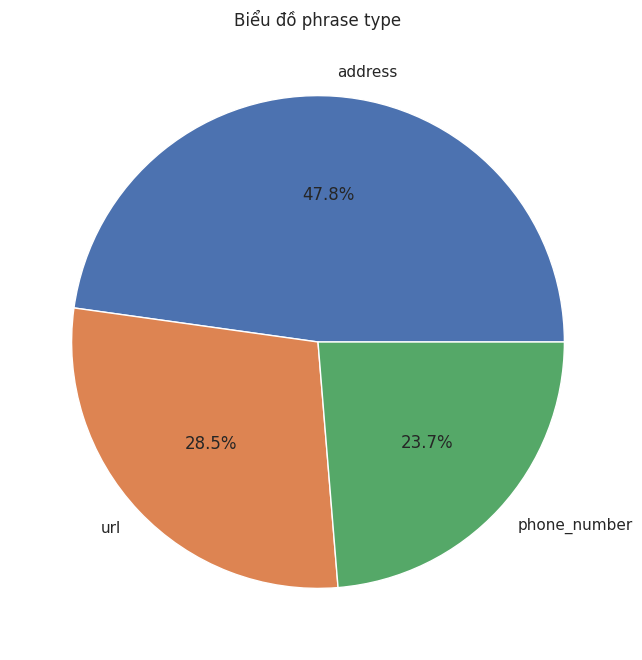

In [51]:
plt.figure(figsize=(16, 8))
train_df['phrase_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Biểu đồ phrase type')
plt.ylabel('')

### Frame

In [52]:
train_df[train_df.file_id==5414471].head()


,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,phrase_type
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,address
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,url
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,address
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,address
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,address


In [53]:
file_id = 1019715464
sequence_id= 1975433633
path_to_sign = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"

In [54]:
sign = pd.read_parquet(path_to_sign)
sign

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1975433633       0  0.578892  0.578482  0.582906  0.572686  0.579030   
1975433633       1  0.577563  0.578528  0.582916  0.572760  0.579090   
1975433633       2  0.576181  0.576949  0.581346  0.572293  0.577725   
1975433633       3  0.575575  0.577569  0.581769  0.572443  0.578289   
1975433633       4  0.577907  0.577628  0.582295  0.572930  0.578345   
...            ...       ...       ...       ...       ...       ...   
2008677531      70  0.684853  0.672752  0.679297  0.670935  0.673818   
2008677531      71  0.683502  0.672031  0.678687  0.671496  0.673336   
2008677531      72  0.688159  0.678438  0.683336  0.675476  0.679688   
2008677531      73       NaN       NaN       NaN       NaN       NaN   
2008677531      74  0.676690  0.677324  0.680541  0.673337  0.678965   

             x_face_5  x_face_6  x_face_7  x_face_8  x_face_9  x_face_10  \
sequence_id                                                                
1975433633   0.582115  0.591430  0.498995  0.595773  0.596977   0.605065   
1975433633   0.582197  0.591687  0.497613  0.596104  0.597340   0.605690   
1975433633   0.581191  0.591550  0.497113  0.596477  0.598010   0.607338   
1975433633   0.581652  0.591728  0.496759  0.596573  0.598046   0.606920   
1975433633   0.581873  0.592467  0.498170  0.597383  0.598794   0.607799   
...               ...       ...       ...       ...       ...        ...   
2008677531   0.679804  0.697755  0.591439  0.707091  0.709658   0.722025   
2008677531   0.679910  0.699268  0.590744  0.709342  0.712169   0.725071   
2008677531   0.685293  0.701444  0.591098  0.710164  0.712766   0.724418   
2008677531        NaN       NaN       NaN       NaN       NaN        NaN   
2008677531   0.684380  0.699804  0.582023  0.709031  0.712111   0.725354   

             x_face_11  x_face_12  x_face_13  x_face_14  x_face_15  x_face_16  \
sequence_id                                                                     
1975433633    0.578535   0.578844   0.579911   0.579761   0.578647   0.577652   
1975433633    0.577165   0.577554   0.578782   0.578465   0.577141   0.575957   
1975433633    0.575816   0.576288   0.577569   0.577347   0.575997   0.574820   
1975433633    0.575234   0.575716   0.577008   0.576686   0.575360   0.574225   
1975433633    0.577483   0.577828   0.578944   0.578837   0.577645   0.576605   
...                ...        ...        ...        ...        ...        ...   
2008677531    0.684202   0.683773   0.683899   0.681701   0.680682   0.679422   
2008677531    0.682318   0.681331   0.681079   0.678583   0.676719   0.674545   
2008677531    0.686857   0.685587   0.685055   0.682453   0.680640   0.678432   
2008677531         NaN        NaN        NaN        NaN        NaN        NaN   
2008677531    0.675767   0.675149   0.675266   0.673786   0.672062   0.670221   

             x_face_17  x_face_18  x_face_19  x_face_20  x_face_21  x_face_22  \
sequence_id                                                                     
1975433633    0.577231   0.581995   0.579889   0.569285   0.456557   0.535281   
1975433633    0.575449   0.582145   0.579924   0.569081   0.456137   0.535068   
1975433633    0.574349   0.579356   0.578282   0.567548   0.460338   0.535383   
1975433633    0.573810   0.579847   0.578909   0.568321   0.457174   0.533959   
1975433633    0.576188   0.580676   0.579090   0.568772   0.459536   0.536419   
...                ...        ...        ...        ...        ...        ...   
2008677531    0.678277   0.674290   0.674900   0.662799   0.564212   0.635209   
2008677531    0.672641   0.671311   0.674193   0.662512   0.567207   0.636544   
2008677531    0.676503   0.675628   0.680109   0.667408   0.559093   0.635111   
2008677531         NaN        NaN        NaN        NaN        NaN        NaN   
2008677531    0.668953   0.670737   0.678434   0.664478   0.5

In [55]:
sequence = sign[sign.index == sequence_id]
sequence

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1975433633       0  0.578892  0.578482  0.582906  0.572686  0.579030   
1975433633       1  0.577563  0.578528  0.582916  0.572760  0.579090   
1975433633       2  0.576181  0.576949  0.581346  0.572293  0.577725   
1975433633       3  0.575575  0.577569  0.581769  0.572443  0.578289   
1975433633       4  0.577907  0.577628  0.582295  0.572930  0.578345   
...            ...       ...       ...       ...       ...       ...   
1975433633     122  0.580664  0.578658  0.582696  0.573646  0.579468   
1975433633     123  0.579410  0.577537  0.581614  0.572913  0.578413   
1975433633     124  0.579054  0.578381  0.582180  0.572766  0.579103   
1975433633     125  0.575100  0.575645  0.579448  0.570512  0.576460   
1975433633     126  0.575272  0.574606  0.578756  0.569679  0.575378   

             x_face_5  x_face_6  x_face_7  x_face_8  x_face_9  x_face_10  \
sequence_id                                                                
1975433633   0.582115  0.591430  0.498995  0.595773  0.596977   0.605065   
1975433633   0.582197  0.591687  0.497613  0.596104  0.597340   0.605690   
1975433633   0.581191  0.591550  0.497113  0.596477  0.598010   0.607338   
1975433633   0.581652  0.591728  0.496759  0.596573  0.598046   0.606920   
1975433633   0.581873  0.592467  0.498170  0.597383  0.598794   0.607799   
...               ...       ...       ...       ...       ...        ...   
1975433633   0.582842  0.592753  0.500169  0.597509  0.598994   0.607791   
1975433633   0.581925  0.592164  0.499362  0.597124  0.598695   0.608041   
1975433633   0.582234  0.591462  0.498055  0.595899  0.597273   0.605365   
1975433633   0.579713  0.589228  0.497017  0.593862  0.595351   0.604132   
1975433633   0.578727  0.588578  0.496531  0.593252  0.594692   0.603580   

             x_face_11  x_face_12  x_face_13  x_face_14  x_face_15  x_face_16  \
sequence_id                                                                     
1975433633    0.578535   0.578844   0.579911   0.579761   0.578647   0.577652   
1975433633    0.577165   0.577554   0.578782   0.578465   0.577141   0.575957   
1975433633    0.575816   0.576288   0.577569   0.577347   0.575997   0.574820   
1975433633    0.575234   0.575716   0.577008   0.576686   0.575360   0.574225   
1975433633    0.577483   0.577828   0.578944   0.578837   0.577645   0.576605   
...                ...        ...        ...        ...        ...        ...   
1975433633    0.580207   0.580229   0.580914   0.580812   0.579820   0.578794   
1975433633    0.578912   0.578921   0.579612   0.579462   0.578375   0.577272   
1975433633    0.578621   0.578667   0.579368   0.579352   0.578366   0.577399   
1975433633    0.574686   0.574872   0.575764   0.575579   0.574348   0.573186   
1975433633    0.574856   0.575065   0.575981   0.575906   0.574708   0.573584   

             x_face_17  x_face_18  x_face_19  x_face_20  x_face_21  x_face_22  \
sequence_id                                                                     
1975433633    0.577231   0.581995   0.579889   0.569285   0.456557   0.535281   
1975433633    0.575449   0.582145   0.579924   0.569081   0.456137   0.535068   
1975433633    0.574349   0.579356   0.578282   0.567548   0.460338   0.535383   
1975433633    0.573810   0.579847   0.578909   0.568321   0.457174   0.533959   
1975433633    0.576188   0.580676   0.579090   0.568772   0.459536   0.536419   
...                ...        ...        ...        ...        ...        ...   
1975433633    0.578158   0.579833   0.579894   0.569287   0.456786   0.536884   
1975433633    0.576573   0.578516   0.578778   0.568386   0.457466   0.536362   
1975433633    0.576847   0.579605   0.579572   0.568907   0.453242   0.534309   
1975433633    0.572541   0.576620   0.576813   0.566362   0.453008   0.533333   
1975433633    0.572995   0.576402   0.575897   0.565693   0.4

In [56]:
# # Loop over all parquet files and collect data
# frames = {} # Save total frames as a dict
# file_list = train_df["path"].unique() # List of files
# for index, path in enumerate(file_list):
#     df = sign # read the corresponding parquet file into a dataframe
#     frame_count = df.groupby(df.index)["frame"].count().tolist() # count the number of frames and store into an array
#     frames[path.split("/")[1].split(".")[0]] = frame_count # parse the label for the file
# def plot_frame_distribution(frames):
#     fig = make_subplots(
#         rows=1,
#         cols=1,  # Số cột giảm xuống 1
#         horizontal_spacing=0.01
#     )

#     for key in frames.keys():
#         trace1 = go.Scatter(
#             y=frames[key],
#             name=key,
#             hovertemplate='Sequence Number: <b>%{x}</b><br>Number of frames: <b>%{y}</b><extra></extra>',
#             marker_color='#484bfa',
#             opacity=0.75,
#         )
#         fig.add_trace(trace1)
#     length_of_data = len(fig.data)
#     length_of_frames = len(frames.keys())
#     for data in range(1, length_of_data):
#         fig.update_traces(visible=False, selector=data)
#     fig.show
# plot_frame_distribution(frames)


In [57]:
# train_df

## Face Landmarks (Khuôn mặt): 468 điểm đặc trưng. Left Hand Landmarks (Tay trái): 21 điểm đặc trưng. Pose Landmarks (Tư thế cơ thể): 33 điểm đặc trưng. Right Hand Landmarks (Tay phải): 21 điểm đặc trưng. 468 (face) + 21 (left hand) + 33 (pose) + 21 (right hand) = 543 *3(x,y,z) = 1629

In [58]:
# sequence_phrase = get_phrase(train_df, file_id, sequence_id)
# visualise2d_landmarks(sequence, f"Phrase: {sequence_phrase}")

### Bỏ z

In [59]:
# def get_cols(df, words_pos, words_neg=[], ret_names=True):
#     cols = []
#     names = []
#     for col in df.columns:
#         # Check if column name contains all words
#         if all([w in col for w in words_pos]) and all([w not in col for w in words_neg]):
#             cols.append(df[col])  # Append the entire column to the list
#             names.append(col)

#     if ret_names:
#         return cols, names
#     else:
#         return cols

In [60]:
# # Landmark Indices for Left/Right hand without z axis in raw data
# LH_Index, LEFT_HAND_NAME = get_cols(sign, ['left_hand'], ['z'])
# RH_Index,RIGHT_HAND_NAME = get_cols(sign, ['right_hand'], ['z'])
# POSE_Index,POSE_NAME=get_cols(sign,['pose'],['z'])
# LIPS_Index, LIPS_NAME = get_cols(sign, ['face'], ['z'])
# # POSE_NAME.insert(0, "frame")
# # LIPS_NAME.insert(0, "frame")
# RIGHT_HAND_NAME.insert(0, "frame")
# # LEFT_HAND_NAME.insert(0, "frame")
# COLUMNS = np.concatenate((LEFT_HAND_NAME, RIGHT_HAND_NAME))
# N_COLS0 = len(COLUMNS)

# print(f'Total number of columns: {N_COLS0}')

### % NA từng bộ phận 

In [61]:
# POSE = sign.loc[:, POSE_NAME] 
# LIPS = sign.loc[:, LIPS_NAME] 
# RIGHT_HAND = sign.loc[:, RIGHT_HAND_NAME] 
# LEFT_HAND = sign.loc[:, LEFT_HAND_NAME] 
# RIGHT_HAND

In [62]:
# print(f"Percentage of nulls in Left Hand data = {100*np.mean(LEFT_HAND['x_left_hand_0'].isnull()):.02f} %")
# print(f"Percentage of nulls in Right Hand data = {100*np.mean(RIGHT_HAND['x_right_hand_0'].isnull()):.02f} %")
# print(f"Percentage of nulls in Pose data = {100*np.mean(POSE['x_pose_0'].isnull()):.02f}%")
# print(f"Percentage of nulls in Lips data = {100*np.mean(LIPS['x_face_0'].isnull()):.02f}%")